In [1]:
import sys, argparse, numpy, math, re
import scipy.stats as scipystats
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/')
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/utilities')

import genomic_file_handlers as genome
from bedFileHandler import BedFile

# Deemed colorblind safe: http://colorbrewer2.org/#type=diverging&scheme=PiYG&n=4
highConfColor     ='#1b9e77'
medConfColor      ='#7570b3'
lowConfColor      ='#d95f02'
unclassifiedColor ='black'

reference_dir = '../../../../HCC1395/HighConfidenceCalls/truth_v1.1/'

In [2]:
def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2
    lower = scipystats.beta.ppf(quantile, success, total - success + 1)
    upper = scipystats.beta.ppf(1 - quantile, success + 1, total - success)
    
    if math.isnan(lower): lower = 0
    if math.isnan(upper): upper = 1
        
    return (lower, upper)

In [3]:
exome           = BedFile('/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/human_all_v6_plus_UTR.liftover.to.hg38.sort.bed')
callableLoci    = BedFile('{}/BED/mergeBed.MajorityAlignersCallable.bed'.format(reference_dir))
genomeMinusLoss = BedFile('{}/BED/genome_minus_armlosses.bed'.format(reference_dir))

In [4]:
superset_snv   = '{}/sSNV.MSDUKT.superSet.v1.2.vcf.gz'.format(reference_dir)
superset_indel = '{}/sINDEL.MDKT.superSet.v1.2.vcf.gz'.format(reference_dir)

In [5]:
# Main Somatic SNV Super Set
snv_TVAF      = []
snv_bwaTVAF   = []
snv_Tier      = []
snv_confLevel = []

with genome.open_textfile(superset_snv) as vcfin:

    line_i = vcfin.readline().rstrip()

    while line_i.startswith('#'):
        line_i = vcfin.readline().rstrip()

    while line_i:

        vcf_i = genome.Vcf_line( line_i )

        if ('NonCallable' not in vcf_i.info) and ('ArmLossInNormal' not in vcf_i.info):
        
            snv_TVAF.append( float(vcf_i.get_info_value('TVAF')) )
            snv_bwaTVAF.append( float(vcf_i.get_info_value('bwaTVAF')) )
        
            if re.search(r'(AllPASS|Tier1)', vcf_i.filters):
                snv_Tier.append('Tier1')

            elif re.search(r'Tier2', vcf_i.filters):
                snv_Tier.append('Tier2')
                
            elif re.search(r'Tier3', vcf_i.filters):
                snv_Tier.append('Tier3')
                
            elif re.search(r'(Tier4|REJECT)', vcf_i.filters):
                snv_Tier.append('Tier4')

            if re.search(r'HighConf', vcf_i.filters):
                snv_confLevel.append('HighConf')

            elif re.search(r'MedConf', vcf_i.filters):
                snv_confLevel.append('MedConf')
                
            elif re.search(r'LowConf', vcf_i.filters):
                snv_confLevel.append('LowConf')
                
            elif re.search(r'Unclassified', vcf_i.filters):
                snv_confLevel.append('Unclassified')

        line_i = vcfin.readline().rstrip()

In [6]:
# Main Somatic indel Super Set
indel_TVAF      = []
indel_bwaTVAF   = []
indel_Tier      = []
indel_confLevel = []
indel_size      = []

with genome.open_textfile(superset_indel) as vcfin:

    line_i = vcfin.readline().rstrip()

    while line_i.startswith('#'):
        line_i = vcfin.readline().rstrip()

    while line_i:

        vcf_i = genome.Vcf_line( line_i )

        if ('NonCallable' not in vcf_i.info) and ('ArmLossInNormal' not in vcf_i.info):
            
            indel_size.append( len(vcf_i.altbase) - len(vcf_i.refbase))
            
            indel_TVAF.append( float(vcf_i.get_info_value('TVAF')) )
            indel_bwaTVAF.append( float(vcf_i.get_info_value('bwaTVAF')) )
        
            if re.search(r'(AllPASS|Tier1)', vcf_i.filters):
                indel_Tier.append('Tier1')

            elif re.search(r'Tier2', vcf_i.filters):
                indel_Tier.append('Tier2')
                
            elif re.search(r'Tier3', vcf_i.filters):
                indel_Tier.append('Tier3')
                
            elif re.search(r'(Tier4|REJECT)', vcf_i.filters):
                indel_Tier.append('Tier4')

            if re.search(r'HighConf', vcf_i.filters):
                indel_confLevel.append('HighConf')

            elif re.search(r'MedConf', vcf_i.filters):
                indel_confLevel.append('MedConf')
                
            elif re.search(r'LowConf', vcf_i.filters):
                indel_confLevel.append('LowConf')
                
            elif re.search(r'Unclassified', vcf_i.filters):
                indel_confLevel.append('Unclassified')

        line_i = vcfin.readline().rstrip()

In [7]:
snv_confLevel   = np.array(snv_confLevel)
indel_confLevel = np.array(indel_confLevel)

snv_TVAF    = np.array(snv_TVAF)
snv_bwaTVAF = np.array(snv_bwaTVAF)
snv_Tier    = np.array(snv_Tier)

indel_TVAF    = np.array(indel_TVAF)
indel_bwaTVAF = np.array(indel_bwaTVAF)
indel_Tier    = np.array(indel_Tier)
indel_size    = np.array(indel_size)

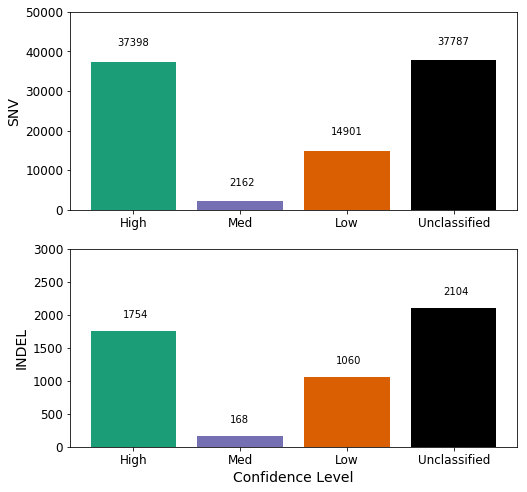

In [8]:
_ = plt.figure( figsize=(8,8))

# SNV
ax1 = plt.subplot(211)
_ = ax1.bar( (1,2,3,4), (sum( snv_confLevel=='HighConf'), \
                         sum( snv_confLevel=='MedConf' ), \
                         sum( snv_confLevel=='LowConf' ), \
                         sum( snv_confLevel=='Unclassified' )), \
                         color=(highConfColor, medConfColor, lowConfColor, unclassifiedColor))

_ = plt.xticks( (1,2,3,4), ('','','','' ))
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.ylabel('SNV', size=14)
_ = plt.ylim((0, 50000))

_ = plt.text( 1-0.15, sum( snv_confLevel=='HighConf')     +4000, sum( snv_confLevel=='HighConf'     ) )
_ = plt.text( 2-0.1,  sum( snv_confLevel=='MedConf'  )    +4000, sum( snv_confLevel=='MedConf'      ) )
_ = plt.text( 3-0.15, sum( snv_confLevel=='LowConf' )     +4000, sum( snv_confLevel=='LowConf'      ) )
_ = plt.text( 4-0.15, sum( snv_confLevel=='Unclassified' )+4000, sum( snv_confLevel=='Unclassified' ) )


# INDEL
ax2 = plt.subplot(212, sharex=ax1)

_ = ax2.bar( (1,2,3,4), (sum( indel_confLevel=='HighConf' ), \
                         sum( indel_confLevel=='MedConf' ), \
                         sum( indel_confLevel=='LowConf' ), \
                         sum( indel_confLevel=='Unclassified' )), \
                         color=(highConfColor, medConfColor, lowConfColor, unclassifiedColor))

_ = plt.xticks( (1,2,3,4), ('High', 'Med', 'Low', 'Unclassified') )
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.xlabel('Confidence Level', size=14)
_ = plt.ylabel('INDEL', size=14)
_ = plt.ylim((0, 3000))

_ = plt.text( 1-0.1, sum( indel_confLevel=='HighConf')     +200, sum( indel_confLevel=='HighConf'     ) )
_ = plt.text( 2-0.1, sum( indel_confLevel=='MedConf'  )    +200, sum( indel_confLevel=='MedConf'      ) )
_ = plt.text( 3-0.1, sum( indel_confLevel=='LowConf' )     +200, sum( indel_confLevel=='LowConf'      ) )
_ = plt.text( 4-0.1, sum( indel_confLevel=='Unclassified' )+200, sum( indel_confLevel=='Unclassified' ) )

plt.savefig('../Main_Figures/Fig_2a_confidence_levels.pdf', bbox_inches='tight')

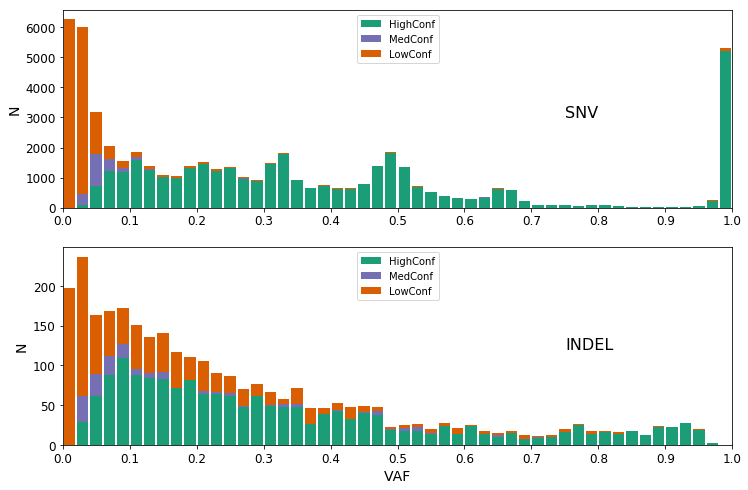

In [9]:
# With LowConf

_ = plt.figure(figsize=(12,8))

nbins=51

# SNV
ax1 = plt.subplot(211)
t4 = plt.hist( snv_TVAF[snv_confLevel=='HighConf'], bins=np.linspace(0,1,nbins), rwidth=0.85, color=highConfColor, )
t3 = plt.hist( snv_TVAF[snv_confLevel=='MedConf'], bins=np.linspace(0,1,nbins), rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( snv_TVAF[snv_confLevel=='LowConf'], bins=np.linspace(0,1,nbins), rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])

_ = plt.xlim((0,1))
_ = plt.xticks( np.linspace(0,1,11) )
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.legend(('HighConf', 'MedConf', 'LowConf'), loc='upper center')
_ = plt.ylabel('N', size=14)
_ = plt.text(0.75, 3000, 'SNV', size=16)


# INDEL
ax2 = plt.subplot(212, sharex=ax1)

t4 = plt.hist( indel_TVAF[indel_confLevel=='HighConf'], bins=np.linspace(0,1,nbins), rwidth=0.85, color=highConfColor, )
t3 = plt.hist( indel_TVAF[indel_confLevel=='MedConf'],  bins=np.linspace(0,1,nbins), rwidth=0.85, color=medConfColor, bottom=t4[0] )
t2 = plt.hist( indel_TVAF[indel_confLevel=='LowConf'],  bins=np.linspace(0,1,nbins), rwidth=0.85, color=lowConfColor, bottom=t4[0]+t3[0])

_ = plt.xlim((0,1))
_ = plt.xticks( np.linspace(0,1,11) )
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.xlabel('VAF', size=14)
_ = plt.legend(('HighConf', 'MedConf', 'LowConf'), loc='upper center')
_ = plt.ylabel('N', size=14)
_ = plt.text(0.75, 120, 'INDEL', size=16)

plt.savefig('../Main_Figures/Fig_2b_somatic_VAFs.pdf', bbox_inches='tight')

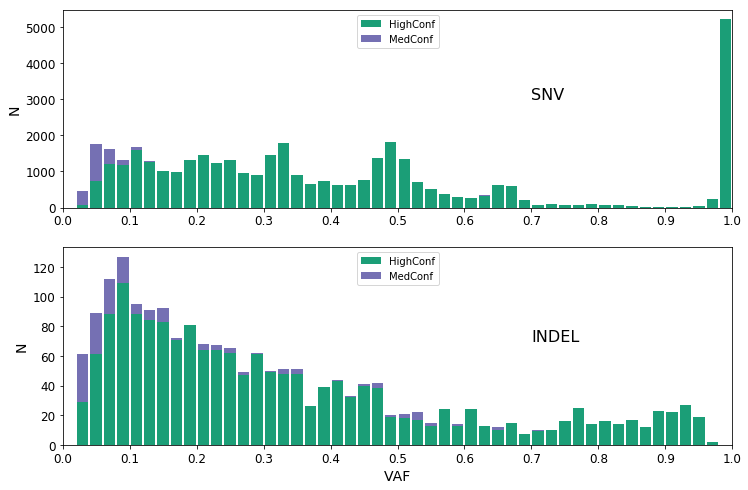

In [10]:
# Without LowConf

_ = plt.figure(figsize=(12,8))

nbins=51

# SNV
ax1 = plt.subplot(211)
t4 = plt.hist( snv_TVAF[snv_confLevel=='HighConf'], bins=np.linspace(0,1,nbins), rwidth=0.85, color=highConfColor, )
t3 = plt.hist( snv_TVAF[snv_confLevel=='MedConf'],  bins=np.linspace(0,1,nbins), rwidth=0.85, color=medConfColor, bottom=t4[0] )

_ = plt.xlim((0,1))
_ = plt.xticks( np.linspace(0,1,11) )
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.legend(('HighConf', 'MedConf', 'LowConf'), loc='upper center')
_ = plt.ylabel('N', size=14)
_ = plt.text(0.7, 3000, 'SNV', size=16)


# INDEL
ax2 = plt.subplot(212, sharex=ax1)

t4 = plt.hist( indel_TVAF[indel_confLevel=='HighConf'], bins=np.linspace(0,1,nbins), rwidth=0.85, color=highConfColor, )
t3 = plt.hist( indel_TVAF[indel_confLevel=='MedConf'],  bins=np.linspace(0,1,nbins), rwidth=0.85, color=medConfColor, bottom=t4[0] )

_ = plt.xlim((0,1))
_ = plt.xticks( np.linspace(0,1,11) )
_ = plt.tick_params(axis='both', which='major', labelsize=12)
_ = plt.xlabel('VAF', size=14)
_ = plt.legend(('HighConf', 'MedConf', 'LowConf'), loc='upper center')
_ = plt.ylabel('N', size=14)
_ = plt.text(0.7, 70, 'INDEL', size=16)

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_08a_VAF_of_somatic_mutations.pdf', bbox_inches='tight')

/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


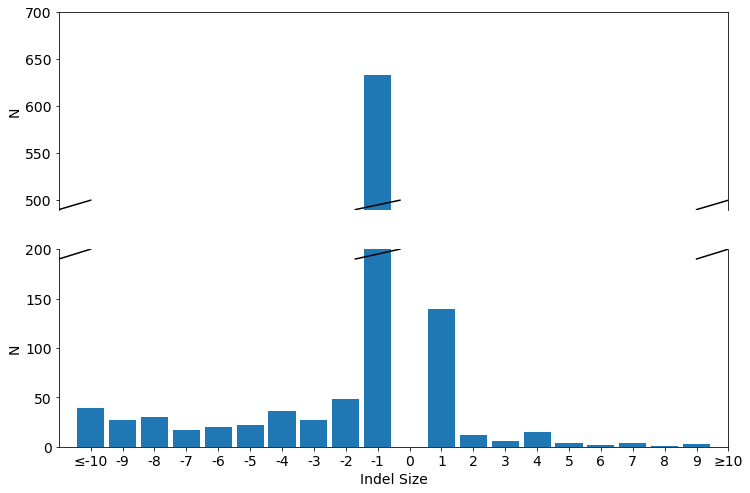

In [11]:
# Figure 2D: indel size
xbins = np.linspace(-10,10,21)
xbinlabels = np.linspace(-10,10,21)

xTicks     = [int(i) for i in xbinlabels]
xTicks[0]  = '≤' + str(xTicks[0])
xTicks[-1] = '≥' + str(xTicks[-1])

_ = plt.figure(figsize=(12,8))

# SNV
ax1 = plt.subplot(211)

_ = plt.hist( (indel_size[np.any( (indel_confLevel == 'HighConf', indel_confLevel == 'MedConf'), axis=0 )]), bins=xbins, rwidth=0.85, align='left' )
_ = plt.ylabel('N', size=14)
_ = plt.tick_params(axis='both', which='major', labelsize=14)
_ = ax1.axes.get_xaxis().set_visible(False)
_ = plt.ylim((490,700))

# INDEL
ax2 = plt.subplot(212, sharex=ax1)

#_ = plt.hist( (  np.clip(indel_size[np.all((indel_SRorWK,indelNotArmLoss), axis=0)] , -10, 10) ), bins=xbins, rwidth=0.85, align='left' )
_ = plt.hist( ( indel_size[np.any( (indel_confLevel == 'HighConf', indel_confLevel == 'MedConf'), axis=0 )] ), bins=xbins, rwidth=0.85, align='left' )
_ = plt.tick_params(axis='both', which='major', labelsize=14)
_ = plt.xticks(xbinlabels, xTicks, fontsize=12,)
_ = plt.ylabel('N', size=14)
_ = plt.xlabel('Indel Size', size=14)
_ = plt.tick_params(axis='both', which='major', labelsize=14)
_ = plt.ylim((0,200))

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

_ = plt.xlim((-11,10))


# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

ax1.plot((-11, -10),   (490, 500), color='black' )  # top-left diagonal
ax1.plot((9, 10),      (490, 500), color='black' )  # top-right diagonal
ax1.plot((-1.7, -0.3), (490, 500), color='black' )  

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-11, -10),   (190, 200), color='black')  # bottom-left diagonal
ax2.plot((9, 10),      (190, 200), color='black')  # bottom-right diagonal
ax2.plot((-1.7, -0.3), (190, 200), color='black')  # bottom-right diagonal

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_03d_indel_sizes.pdf', bbox_inches='tight')